# Comparison of acquisition functions in Bayesian optimization of ocean acoustic waveguides using Gaussian processes
For JASA Express Letters

## Abstract
Geoacoustic model optimization and inversion are computationally expensive endeavors. In cases where a parameter grid search is prohibitively expensive, optimization produces an approximated solution through sampling techniques such as Markov chain Monte Carlo, simulated annealing, and genetic algorithms.  More recent work proposes replacing such sampling with a Bayesian approach that uses a Gaussian process as a surrogate model of the objective function.  The surrogate model represents the posterior on the objective function and is updated with each sample evaluation.  As an alternative to sampling methods listed above, acquisition functions incorporate the uncertainty in the posterior to select the next point to be sampled and can greatly speed the optimization.  In this study, four common acquisition functions are described encompassing approaches that use manual tuning (upper confidence bound), improvement criteria (probability of improvement and expected improvement), and information criteria (entropy search).  Results are presented from an acoustic parameter search for a shallow water waveguide for each function.  Expected improvement is found to be the preferred acquisition function for the simulations, converging on the optimal solution more quickly than the other acquisition functions.

## 1. Introduction



## 2. Bayesian optimization using a Gaussian process

In Bayesian optimization, 

In [1]:
import math
import time

import torch
from botorch import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement, ProbabilityOfImprovement
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.utils.transforms import standardize, normalize
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
torch.manual_seed(123456)

Define a true objective function

Text(0.5, 1.0, 'True Objective Function; Min = (2.70, 1.90)')

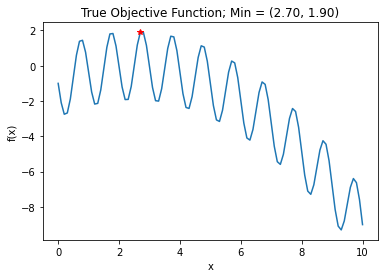

In [88]:
def f(x, negate=False):
    f = (0.4 * x - 1)**2 + 2*torch.sin(2 * math.pi * x)
    if negate:
        f = -f
    return f

x = torch.linspace(0, 10, 101)
y = f(x, negate=True)
x_min = x[torch.argmax(y)]
y_min = torch.max(y)
GLOBAL_MAXIMUM = y_min

plt.plot(x, y)
plt.plot(x_min, y_min, 'r*')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'True Objective Function; Min = ({x_min:.2f}, {y_min:.2f})')

Draw random, noisy samples from the curve.

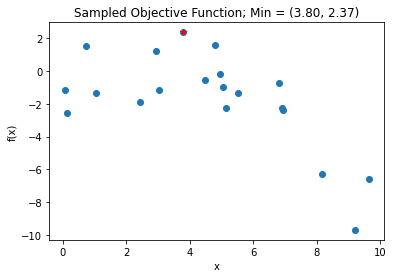

In [89]:
def generate_initial_data(n=5, std=0.5, bounds=torch.tensor([0, 1]), negate=True):
    train_x = bounds[1] * torch.rand(n, 1)
    exact_obj = f(train_x, negate=negate)
    train_obj = exact_obj + std * torch.randn_like(exact_obj)
    return train_x, train_obj


def normalize_standardize(train_x, train_obj, bounds):
    train_x = normalize(train_x, bounds=bounds)
    train_obj = standardize(train_obj)
    bounds = normalize(bounds, bounds=bounds)
    return train_x, train_obj, bounds


n = 20
std = 0.5
bounds = torch.tensor([0, 10])

train_x, train_obj = generate_initial_data(n=n, std=std, bounds=bounds)
x_min = train_x[torch.argmax(train_obj)].detach().cpu().numpy().squeeze()
y_min = torch.max(train_obj).detach().cpu().numpy().squeeze()

plt.scatter(train_x, train_obj)
plt.plot(x_min, y_min, 'r*')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Sampled Objective Function; Min = ({x_min:.2f}, {y_min:.2f})')
plt.show()

In [90]:
def initialize_model(train_x, train_obj, state_dict=None):
    model = SingleTaskGP(train_X=train_x, train_Y=train_obj)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [91]:
def optimize_acqf_and_get_observation(acq_func, bounds, batch_size=1, num_restarts=1, raw_samples=1):
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=batch_size,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        options={"batch_limit": 5, "maxiter": 200},
        device=bounds.device
    )
    new_x = candidates.detach()
    exact_obj = f(new_x, negate=True)
    new_obj = exact_obj + std*torch.randn_like(exact_obj)
    return new_x, new_obj


def update_random_observations(bounds, batch_size=1):
    new_x = bounds[1] * torch.rand(batch_size)
    exact_obj = f(new_x, negate=True)
    new_obj = exact_obj + std*torch.randn_like(exact_obj)
    return new_x.unsqueeze(-1), new_obj.unsqueeze(-1)

In [92]:
def _plot_posterior(test_x, train_x, train_obj, model, ax=None):
    with torch.no_grad():
        posterior = model.posterior(test_x)
        lower, upper = posterior.mvn.confidence_region()

        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(6,4))
        ax.plot(train_x.cpu().numpy(), train_obj.cpu().numpy(), 'k*')
        ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)

    return ax

def plot_posteriors(test_x, train_x, train_obj, models, names, **kwargs):

    fig = plt.figure(figsize=(12,4))

    for i in range(len(models)):
        ax = plt.subplot(1, 3, i+1)
        ax = _plot_posterior(test_x, train_x[i], train_obj[i], models[i], ax=ax)
        ax.set_title(names[i])

    return fig


def acquisition_function(test_x, acqfunc):
    return acqfunc(test_x[:, None, None])


def _plot_acqfunc(test_x, acqfunc, ax=None):
    alpha = acquisition_function(test_x, acqfunc)
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(test_x.detach().cpu().numpy(), alpha.detach().cpu().numpy(), 'k')
    return ax, alpha


def plot_posteriors_and_acqfunc(test_x, train_x, train_obj, models, names, acqfuncs, **kwargs):

    fig = plt.figure(figsize=(12,4))

    for i, acqfunc in enumerate(acqfuncs):
        ax1 = plt.subplot(1, 3, i+1)
        ax1 = _plot_posterior(test_x, train_x[i], train_obj[i], models[i], ax=ax1)
        ax1.set_title(names[i])

        if names[i] == "Random":
            pass
        else:
            ax2 = ax1.twinx()
            ax2, alpha = _plot_acqfunc(test_x, acqfunc, ax=ax2)
            ax1.plot(test_x[torch.argmax(alpha)].detach().cpu().numpy(), alpha.max().detach().cpu().numpy(), 'r*')

    return fig


Iter  1 | best_value_pi = 0.3381 | best_value_ei = 0.3381 | best_value_ra = 0.3381
Iter  2 | best_value_pi = 0.8134 | best_value_ei = 0.3381 | best_value_ra = 0.3381
Iter  3 | best_value_pi = 0.8134 | best_value_ei = 0.3381 | best_value_ra = 0.3381
Iter  4 | best_value_pi = 1.5289 | best_value_ei = 0.3381 | best_value_ra = 0.3381
Iter  5 | best_value_pi = 1.5289 | best_value_ei = 0.3381 | best_value_ra = 0.3381
Iter  6 | best_value_pi = 1.7085 | best_value_ei = 0.4254 | best_value_ra = 0.3381
Iter  7 | best_value_pi = 1.7999 | best_value_ei = 0.4254 | best_value_ra = 0.3381
Iter  8 | best_value_pi = 1.7999 | best_value_ei = 1.7102 | best_value_ra = 1.9381
Iter  9 | best_value_pi = 1.7999 | best_value_ei = 1.7102 | best_value_ra = 1.9381
Iter 10 | best_value_pi = 1.8586 | best_value_ei = 1.7102 | best_value_ra = 1.9381
Iter 11 | best_value_pi = 1.8936 | best_value_ei = 1.7102 | best_value_ra = 1.9381
Iter 12 | best_value_pi = 1.8936 | best_value_ei = 1.7102 | best_value_ra = 1.9381
Ite

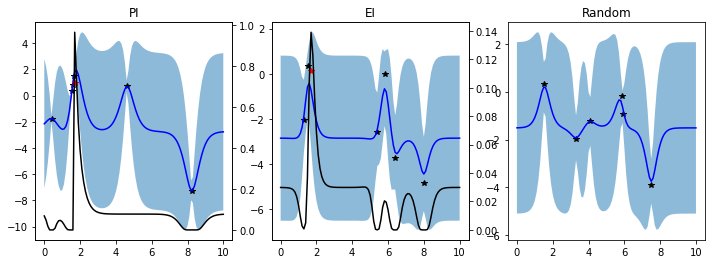

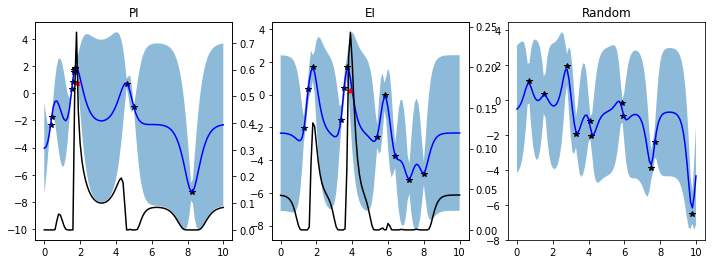

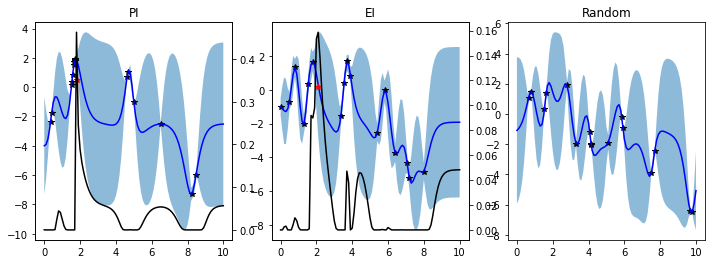

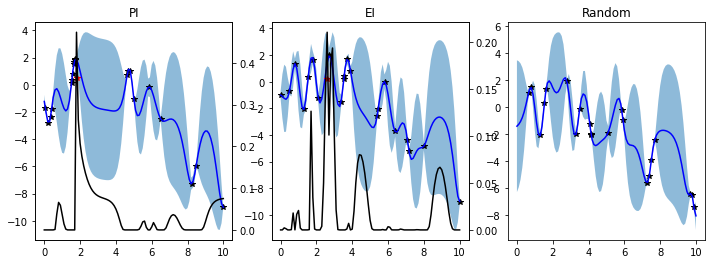

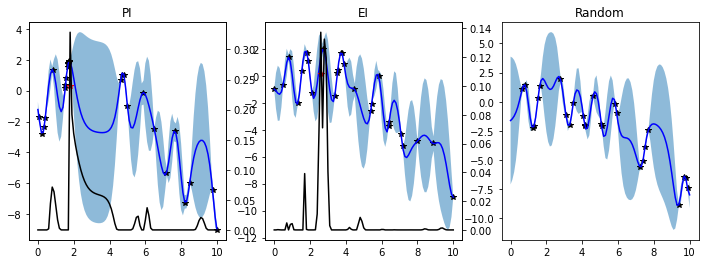

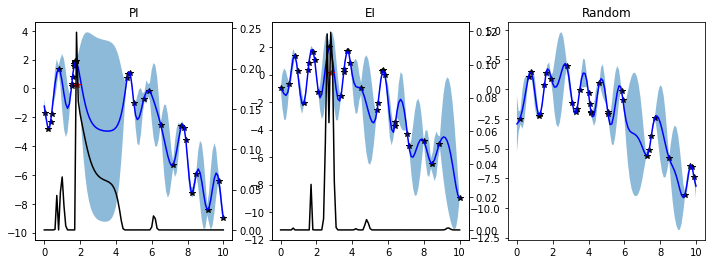

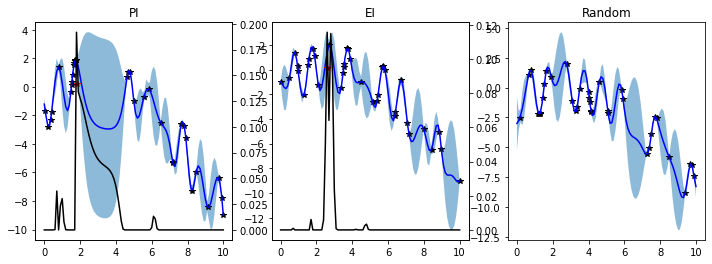

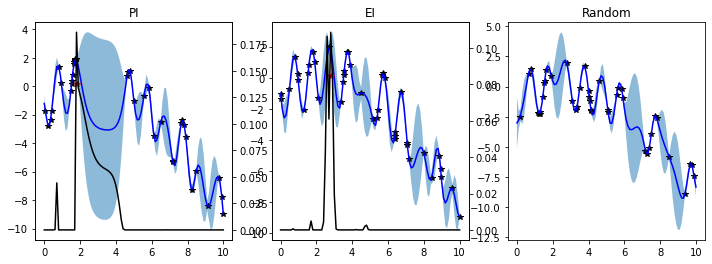

In [93]:
best_observed_ei, best_observed_pi, best_observed_ra = [], [], []

n = 1
std = 0.
n_iter = 40
bounds = torch.tensor([0, 10], dtype=dtype).unsqueeze(-1)

names = ["PI", "EI", "Random"]

test_x = torch.linspace(0, 10, 101, dtype=dtype, device=device)
train_x_pi, train_obj_pi = generate_initial_data(n=n, std=std, bounds=bounds, negate=True)
train_x_ei, train_obj_ei = train_x_pi, train_obj_pi
train_x_ra, train_obj_ra = train_x_pi, train_obj_pi

mll_pi, model_pi = initialize_model(train_x_pi, train_obj_pi)
mll_ei, model_ei = initialize_model(train_x_ei, train_obj_ei)
mll_ra, model_ra = initialize_model(train_x_ra, train_obj_ra)

for iteration in range(1, n_iter+1):
    t0 = time.time()

    # Fit GP model
    fit_gpytorch_model(mll_pi)
    fit_gpytorch_model(mll_ei)
    fit_gpytorch_model(mll_ra)

    # Parameterize the acquisition functions
    PI = ProbabilityOfImprovement(model_pi, best_f=train_obj_pi.max())
    EI = ExpectedImprovement(model_ei, best_f=train_obj_ei.max())
    
    # Evaluate
    new_x_pi, new_obj_pi = optimize_acqf_and_get_observation(PI, bounds)
    new_x_ei, new_obj_ei = optimize_acqf_and_get_observation(EI, bounds)
    new_x_ra, new_obj_ra = update_random_observations(bounds)

    train_x_pi = torch.cat([train_x_pi, new_x_pi])
    train_x_ei = torch.cat([train_x_ei, new_x_ei])
    train_x_ra = torch.cat([train_x_ra, new_x_ra])

    train_obj_pi = torch.cat([train_obj_pi, new_obj_pi])
    train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])
    train_obj_ra = torch.cat([train_obj_ra, new_obj_ra])

    best_value_pi = train_obj_pi.max()
    best_value_ei = train_obj_ei.max()
    best_value_ra = train_obj_ra.max()

    best_observed_pi.append(best_value_pi)
    best_observed_ei.append(best_value_ei)
    best_observed_ra.append(best_value_ra)

    mll_pi, model_pi = initialize_model(train_x_pi, train_obj_pi, model_pi.state_dict())
    mll_ei, model_ei = initialize_model(train_x_ei, train_obj_ei, model_ei.state_dict())
    mll_ra, model_ra = initialize_model(train_x_ra, train_obj_ra, model_ra.state_dict())

    if iteration % 5 == 0:
        train_x = [train_x_pi, train_x_ei, train_x_ra]
        train_obj = [train_obj_pi, train_obj_ei, train_obj_ra]
        models = [model_pi, model_ei, model_ra]
        # fig = plot_posteriors(test_x, train_x, train_obj, models, names)
        fig = plot_posteriors_and_acqfunc(test_x, train_x, train_obj, models, names, [PI, EI, None])

    t1 = time.time()

    print(
        f"\nIter {iteration:>2} | best_value_pi = {best_value_pi:.4f} | best_value_ei = {best_value_ei:.4f} | best_value_ra = {best_value_ra:.4f}"
        # f"\ntime = {t1 - t0:>4.2f}"
        ,
        end=""
    )

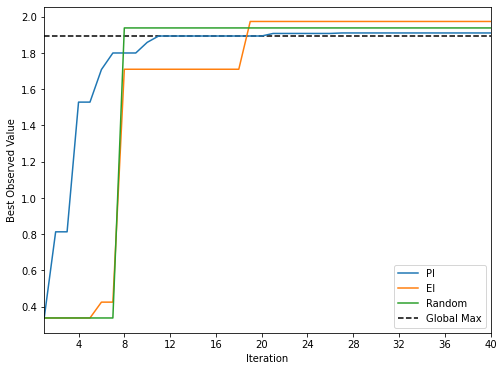

In [94]:
from matplotlib.ticker import MaxNLocator

def plot_best_values(data, names, global_max=None, show=True):
    iterations = range(1, len(data[0]) + 1)

    fig = plt.figure(figsize=(8, 6), facecolor='w')
    for i, name in enumerate(names):
        plt.plot(iterations, data[i], label=name)
    if global_max is not None:
        plt.hlines(global_max, iterations[0], iterations[-1], label="Global Max", colors='k', linestyles='dashed')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlim(iterations[0], iterations[-1])
    plt.xlabel("Iteration")
    plt.ylabel("Best Observed Value")
    plt.legend()

    if show:
        plt.show()
    else:
        plt.close()
    return fig

data = [best_observed_pi, best_observed_ei, best_observed_ra]
names = ["PI", "EI", "Random"]
fig = plot_best_values(data, names, global_max=GLOBAL_MAXIMUM)